In [3]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
import warnings
warnings.simplefilter('ignore')

np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

## ガウシアン推論

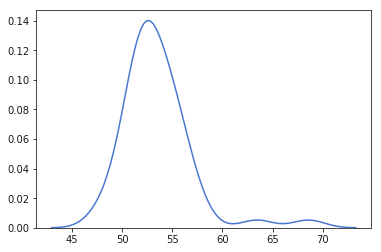

In [5]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34, 55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33, 57.48, 57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73, 51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84, 53.16])

sns.kdeplot(data)

正規分布を仮定する

$$ 
\begin{align}
    \mu &\sim Uniform(l, h) \\
    \sigma &\sim HalfNormal(\sigma_{\sigma}) \\
    y &\sim Normal(\mu, \sigma)
\end{align}
$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 6400/6400 [00:00<00:00, 7247.42draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1330ea198>,
      dtype=object)

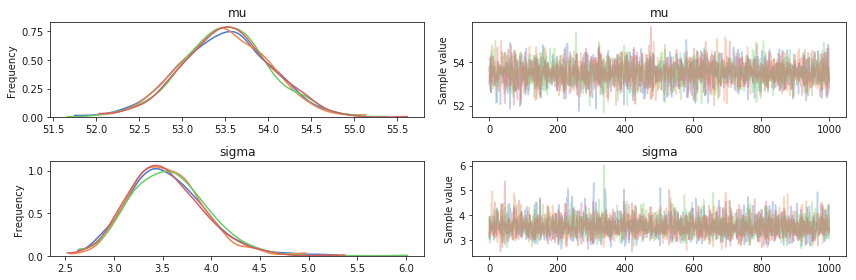

In [7]:
with pm.Model() as model_g:
    mu = pm.Uniform("mu", 40 ,75)
    sigma = pm.HalfNormal("sigma", sd=10)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=data)
    
    trace_g = pm.sample(1100)
chain_g = trace_g[100:]
pm.traceplot(chain_g)

In [9]:
df = pm.summary(chain_g)
df

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,53.50,0.51,8.57e-03,52.49,54.49,3326.85,1.0
sigma,3.55,0.38,7.68e-03,2.81,4.29,3172.23,1.0


100%|██████████| 100/100 [00:00<00:00, 1417.88it/s]


Text(0.5,0,'$x$')

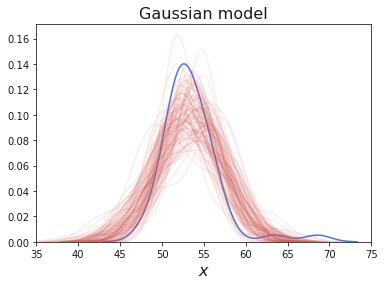

In [11]:
y_pred = pm.sample_ppc(chain_g, 100, model_g, size=len(data))
sns.kdeplot(data, c="b")
for i in y_pred["y"]:
    sns.kdeplot(i[0], c="r", alpha=0.1)
plt.xlim(35, 75)
plt.title("Gaussian model", fontsize=16)
plt.xlabel("$x$", fontsize=16)


## 頑健推論

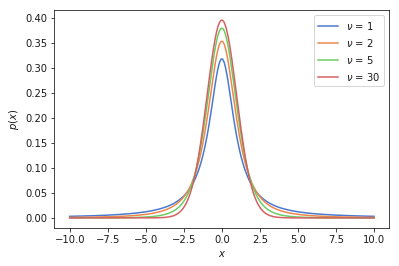

In [16]:
#t分布
x_values = np.linspace(-10, 10, 200)
for df in [1, 2, 5, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=r"$\nu$ = {}".format(df))

x_pdf = stats.norm.pdf(x_values)
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
plt.legend()

$$ 
\begin{align}
    \mu &\sim Uniform(l, h) \\
    \sigma &\sim HalfNormal(\sigma_{\sigma}) \\
    \nu &\sim Exponential(\lambda) \\
    y &\sim StudenT(\mu, \sigma, \mu)
\end{align}
$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, mu]
Sampling 4 chains: 100%|██████████| 6400/6400 [00:01<00:00, 4467.27draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x134b2ce80>,
      dtype=object)

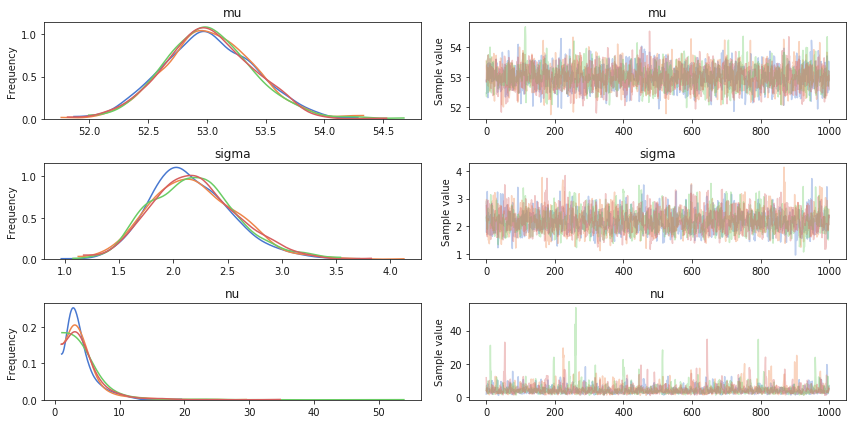

In [19]:
with pm.Model() as model_t:
    mu = pm.Uniform("mu", 40 ,75)
    sigma = pm.HalfNormal("sigma", sd=10)
    nu = pm.Exponential("nu", 1/30)
    
    y = pm.StudentT("y", mu=mu, sd=sigma, nu=nu, observed=data)
    
    trace_t = pm.sample(1100)
chain_t = trace_t[100:]
pm.traceplot(chain_t)


In [20]:
pm.summary(chain_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,53.01,0.38,6.67e-03,52.29,53.76,2930.84,1.0
sigma,2.18,0.40,7.83e-03,1.45,2.95,1942.57,1.0
nu,4.40,3.08,7.74e-02,1.21,9.69,1700.37,1.0


100%|██████████| 100/100 [00:00<00:00, 1027.61it/s]


Text(0.5,0,'$y$')

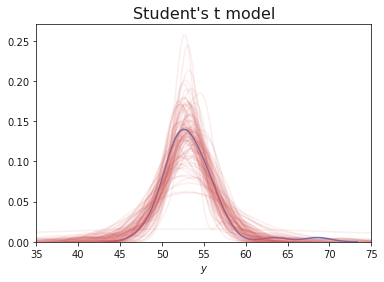

In [27]:
y_pred = pm.sample_ppc(chain_t, 100, model_t, size=len(data))
sns.kdeplot(data, c="b")
for i in y_pred["y"]:
    sns.kdeplot(i[0], c="r", alpha=0.1)
plt.xlim(35, 75)
plt.title("Student's t model", fontsize=16)
plt.xlabel("$y$")

## グループ間の比較

In [47]:
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


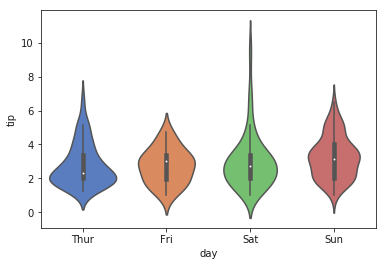

In [48]:
sns.violinplot(x="day", y="tip", data=tips)

In [49]:
y = tips["tip"].values
idx = pd.Categorical(tips["day"]).codes

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sds, means]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:15<00:00, 1451.88draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x138768278>,
      dtype=object)

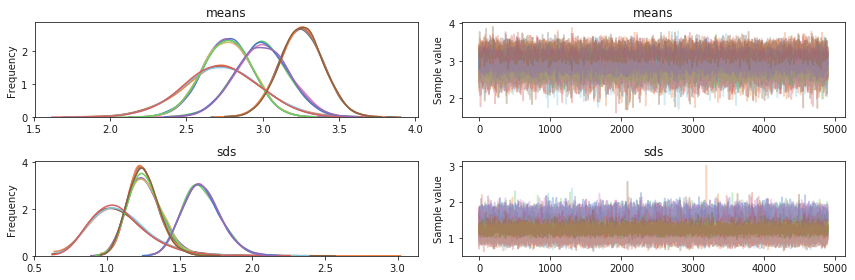

In [50]:
with pm.Model() as comparing_groups:
    means = pm.Normal("means", mu=0, sd=10, shape=len(set(idx)))
    sds = pm.HalfNormal("sds", sd=10, shape=len(set(idx)))
    
    y = pm.Normal("y", mu=means[idx], sd=sds[idx], observed=y)
    
    trace_cg = pm.sample(5000)

chain_cg = trace_cg[100::]
pm.traceplot(chain_cg)

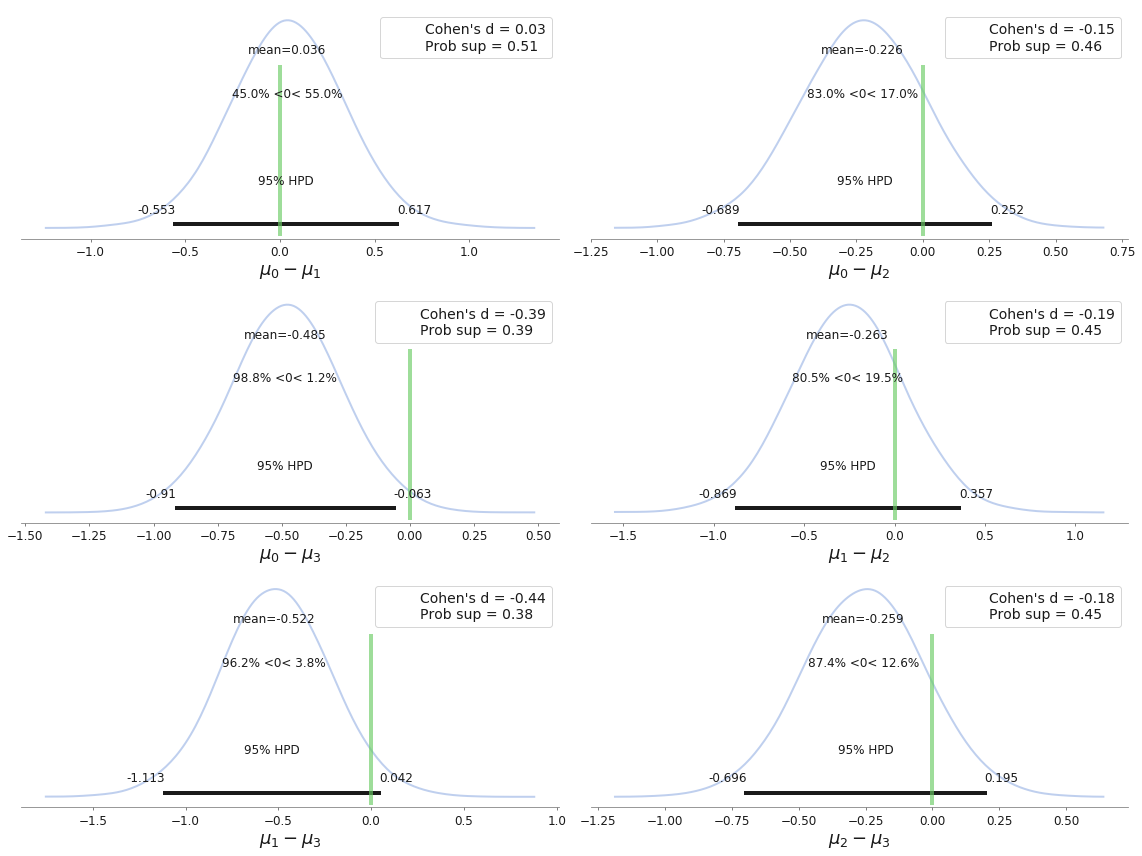

In [51]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(16,12))

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = chain_cg['means'][:,i]-chain_cg['means'][:,j]
    d_cohen = (means_diff / np.sqrt((chain_cg['sds'][:,i]**2 + chain_cg['sds'][:,j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
        
    pm.plot_posterior(means_diff, ref_val=0, ax=ax[k, l], kde_plot=True, lw=2)
    ax[k, l].plot(0, label="Cohen's d = {:.2f}\nProb sup = {:.2f}".format(d_cohen, ps) ,alpha=0)
    ax[k, l].set_xlabel('$\mu_{}-\mu_{}$'.format(i, j), fontsize=18)
    ax[k,l ].legend(loc=0, fontsize=14)
plt.tight_layout()

# 階層モデル

In [56]:
N_samples =  [30, 30, 30]
G_samples =  [18, 18, 18]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = [] 
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i] -  G_samples[i]]))

$$ 
\begin{align}
    \alpha &\sim HalfCaushy(\beta_{\alpha}) \\
    \beta &\sim HalfCaushy(\beta_{\beta}) \\
    \theta &\sim beta(\alpha, \beta) \\
    y &\sim bern(\theta)
\end{align}
$$